In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Scalable Gaussian Processes

We have now seen that Gaussian processes provide an interpretable and flexible approach to function estimation. GPs work directly in function-space, where it possible to directly encode properties such as rate of variation through the covariance function (kernel). Moreover, Gaussian process regression is simple to implement and _reliable_: we get reliable predictions and uncertainty, without significant intervention, through a dozen lines of code. We have also seen that although Gaussian processes are extremely flexible --- with popular kernels corresponding to models with an infinite number of parameters --- they provide very compelling performance on problems with a small number of data points. These results help us understand that highly flexible models need not overfit, as long as they have reasonable inductive biases --- in the language of probability, as long as the functions that are a priori likely are a reasonable description of the problem we are trying to solve. 

But what about larger datasets? Historically, Gaussian processes have not scaled to problems with more than a few thousand training points, which has greatly limited their applicability. However, over the last decade there has been extraordinary progress in making Gaussian processes scalable. This progress in itself is highly consequential, for example making it possible to consider large-scale spatiotemporal prediction problems in climate science, or to create hybrid systems combining Gaussian processes and neural networks that improve performance and have calibrated uncertainty. But how we achieved the progress is also highly instructive for virtually any researcher or practicioner of deep learning at large: scaling Gaussian processes involves reasoning about algebraic problems that are ubiquitous in machine learning. 

These are three computational bottlenecks in working with Gaussian processes: (1) inferring a posterior, (2) learning kernel hyperparameters, and (3) making predictions once we have the posterior and hyperparameters. The first two can broadly be referred to as "training time scalability", and the third as "test time" scalability. We will be examining each of these bottlenecks in turn. We will focus our attention on regression (with potentially noisy targets). The same scalability ideas can be applied fairly directly classification, and situations with non-Gaussian likelihoods, which is what we discuss in the next notebook. As an aside, we have to be careful about language. In general deep learning, "inference time" is often used to mean what we refer to here as "test time". However, in Bayesian and most statistical machine learning, inference means inferring a posterior, which is more akin to training than testing. 

_Will add an opening figure that shows a striking result of standard vs scalable approaches_

## Predictive Equations

Let's now return to the equations we use to make predictions and learn kernel hyperparameters. Suppose we have data $\mathcal{D} = \{x_i,y_i\}_{i=1}^n$. We assume that our data are generated by an underlying noise-free Gaussian process $f(x) \sim \mathcal{GP}(m,k)$ plus Gaussian noise: $y(x) = f(x) + \epsilon(x)$, where $\epsilon(x) \sim \mathcal{N}(0,\sigma^2)$. Equivalently, $y(x)|f(x),\sigma^2 \sim \mathcal{N}(f(x),\sigma^2)$. For notational simplicity, we will set the mean function of the Gaussian process $m(x) = 0$. We wish to make predictions at a point $x^*_{1:m}$. Let $k(x_{1:n},x_{1:n})$ denote the $n \times n$ kernel matrix formed by evaluating the kernel at all pairs of $n$ training inputs. Let $y_{1:n}$ denote the $n \times 1$ vector of target observations. Let $k(x^*_{1:m},x_{1:n})$ denote the $m \times n$ vector formed by evaluating the kernel at the test input and every training input. Then the predictive equations are as follows.

$p(f(x^*_{1:m})|y_{1:n},\sigma^2,x_{1:n}) = \mathcal{N}(\mu,S)$, where

$\mu = k(x^*_{1:m},x_{1:n})[k(x_{1:n},x_{1:n})+\sigma^2 I]^{-1}y_{1:n}$

$S = k(x^*_{1:m},x^*_{1:m}) - k(x^*_{1:m},x_{1:n})[k(x_{1:n},x_{1:n})+\sigma^2 I]^{-1}k(x_{1:n},x^*_{1:m})$

Note that we are rarely interested in evaluating the full predictive covariance matrix $S$, but instead use the diagonal of this matrix for uncertainties. A convenient way of finding the diagonal is simply to substitute $x^*_{1:m}$ with a single test point $x^*$, in which case for instance $k(x^*,x^*)$ is a scalar rather than an $m \times m$ matrix, and evaluate for any test points of interest. 

The kernel is parametrized by $\theta$. For example, if we are using the RBF kernel we have amplitude and length-scale hyperparameters, $a$ and $\ell$, $k_{\text{RBF}}(x_i,x_j) = a^2 \exp\left(-\frac{1}{2\ell^2}||x_i-x_j||^2\right)$. In the above equations we have suppressed the dependence on $\theta$ for notational convenience. If we wish to learn $\theta$ and $\sigma^2$, we can maximize the log marginal likelihood:

$\log p(y_{1:n}|\theta, \sigma^2, x_{1:n}) = -\frac{1}{2}y_{1:n}^{\top}[k_{\theta}(x_{1:n},x_{1:n})+\sigma^2 I]^{-1}y_{1:n} - \frac{1}{2}\log|k_\theta(x_{1:n},x_{1:n})+\sigma^2I|$ + c.

In previous sections, we have already provided these equations, and their interpretations. Our goal here is to understand how to evaluate them efficiently. 

## Training Time Complexity 

Any of the terms in the above equations not involving $x^*$ are computations we do at training time. For posterior inference, we must compute 

$[k_{\theta}(x_{1:n},x_{1:n})+\sigma^2I]^{-1}y_{1:n}$.

and for learning hyperparameters we must additionally evaluate 

$\log|k_\theta(x_{1:n},x_{1:n})|$,

and its derivatives with respect to $\theta$.

Historically, one starts by taking the Cholesky decomposition of $K = k_{\theta}(x_{1:n},x_{1:n})+\sigma^2I$ into $K=LL^{\top}$, where $L$ is a lower triangular matrix. The Cholesky decomposition requires $\mathcal{O}(n^3)$ computations, after which $K^{-1}y_{1:n}$ requires $\mathcal{O}(n^2)$ computations and \log|k_\theta(x_{1:n},x_{1:n})| and its derivatives can computed in $\mathcal{O}(n)$ computations. The memory bottleneck is storing $K$, which requires $\mathcal{O}(n^2)$ memory. 

In short, standard procedures for training a GP require $\mathcal{O}(n^3)$ computations and $\mathcal{O}(n^2)$ storage for $n$ training data points, arising from taking a Cholesky decomposition of $K$ and storing its entries.

## Testing Time Complexity 

At test time, we can assume we have already solved and stored $\alpha = K^{-1}y_{1:n}$, as well as the Cholesky decomposition of $K$. 

To make point predictions at $m$ points we must evaluate $k(x^*_{1:m},x_{1:n})\alpha$. Multiplying an $m \times n$ matrix against an $n \times n$ vector costs at most $\mathcal{O}(mn)$. In other words, each point prediction costs at most $\mathcal{O}(n)$ computations. 

If we wish to have uncertainty at each single test point $x^*$, then we must evaluate
$k(x^*,x^*) - k(x^*,x_{1:n})K^{-1}k(x_{1:n},x^*)$. The computational is $K^{-1}k(x_{1:n},x^*)$ which requires $\mathcal{O}(n^2)$ computations since we have the Cholesky decomposition of $K$.

We see that each of these functions are entirely consistent with our data, perfectly running through each observation. In order to use these posterior samples to make predictions, we can average the values of every possible sample function from the posterior, to create the curve below, in thick blue. Note that we don't actually have to take an infinite number of samples to compute this expection; as we will see later, we can compute the expectation in closed form.  

In some instances, we may wish to compute the posterior predictive covariance matrix over all test points $x^*_{1:m}$. The most common reason to do this is to take _samples_ of the posterior predictive at the test points. In fact, we have taken posterior samples many times for intuition in previous notebooks. An increasingly common reason to take posterior samples is in evaluating acquisition functions for Bayesian optimization (see Chapter ??). Assuming a Cholesky decomposition approach, and having pre-computed everything possible at train-time, drawing $s$ samples requires $\mathcal{O}(mn^2 + m^2(n + s) + m^3)$ computations.

## An Overview of Approaches to Scalable Gaussian Processes

Almost all efforts to improve GP scalability have focused on training time, which naively requires a daunting $\mathcal{O}(n^3)$ computations using conventional approaches. We summarize each of these approaches, and then discuss Krylov subspace methods, which form the simplest and most general approaches to date, in greater detail. At the end of this section, we will discuss scalable test time computations.

**Krylov Subspace Methods**

In an overwhelming majority of use-cases for scalable Gaussian processes, you need not read further than Krylov subspace methods. The name sounds fancy, but these are the simplest, most accurate (often essentially exact), and most broadly applicable family of approaches in use. It is now possible to scale near-exact Gaussian processes to more than a million points on a single GPU, by using Krylov methods. 

The basic idea is simple: use iterative solvers such as linear conjugate-gradients that rely entirely on matrix multiplies. Despite the simplicity, and occasional historical use, these approaches only started to become highly practical and popular for Gaussian processes since 2018. There are two major contributing factors in their modern popularity: (1) the rise of GPU computing. Matrix multiplies can be trivially parallelized, which can be exploited with parallel GPU cores for a highly scalable approach. (2) Carefully engineered and pre-conditioned batch parallel algorithms that simultaneously provide conjugate gradients for linear systems (posterior inference) and stochastic Lanczos triadiagonalization for log determinants (hyperparameter learning), implemented as the backbone for GPyTorch, an easy-to-use library for scalable Gaussian processes. 

With CPU computing, the standard Cholesky based approaches were historically more appealing, due to numerical stability, and the relative lack of design decisions. However, unlike Krylov methods, the Cholesky decomposition is a recursive algorithm that cannot be very effectively parallelized. In general, the advent of GPU computing has completely changed the landscape of how we should think about algorithmic development, and which historical algorithms are the most appealing.

Another advantage of Krylov methods is that if we want to make them faster still we need only consider how to accelerate a matrix multiply, which is relatively easy to reason about. In fact, many of the approaches below can be used to approximate a kernel matrix towards faster multiplies, and then combined with Krylov methods. At the end of this section, we will describe Krylov methods in some more detail, and provide GPyTorch examples.

**Low-rank Approximations**

A common way to scale Gaussian processes is to form a low-rank approximation $\tilde{K}$ of $k(x_{1:n},x_{1:n})$. Then one can apply the Woodbury matrix inversion lemma to the low-rank plus diagonal $\tilde{K}+\sigma^2I$. If $\tilde{K}$ is rank $r$, then these approaches cost $\mathcal{O}(r^2n+r^3)$ computations instead of $\mathcal{O}(n^3)$, and $\mathcal{O}(r^2)$ storage. There are several popular families of approaches in this class, but we will highlight two in particular:

- _Inducing point methods_: these introduce a latent set of inputs $u_{1:r}$ which are called _inducing inputs_. Then the kernel matrix is then approximated as $k(x_{1:n},x_{1:n}) \approx k(u_{1:n},x_{1:n})k(x_{1:n},x_{1:n})k(u_{1:n},x_{1:n})$. The closer the inducing inputs are to the training inputs $x_{1:n}$, the better the approximation. There are many ways to choose the inducing inputs: as a subset of the actual training inputs, using k-means, on a grid, or even by treating their locations as a kernel hyperparameter which is learned through the marginal likelihood. **Pros:** Generally applicable. Can be used regardless of the kernel type (e.g., stationary or non-stationary), input structure, input dimensionality. **Cons:** Only provides a good approximation near the inducing points, meaning the inducing points have to provide reasonable coverage of the domain of interest. Scales poorly with the number of inducing points. Tends to work best for kernels with simple smooth structure (like the RBF kernel). Poor for kernel learning.


- _Random feature expansions_: take the Fourier transform of any stationary kernel to find its _spectral density_. Sample from the spectral density to get a set of frequencies $s_{1:r}$. Use the weight-space model $f(x) = \sum_{i=1}^r a_i sin(2\pi s_i^{\top}x)+b_icos(s_i^{\top}x)$, $a_i, b_i \sim \mathcal{N}(0,\frac{\alpha^2}{r})$. This approach is equivalent to using the rank-r kernel $k(x_i,x_j) = \frac{\alpha^2}{r} \sum_{i=1}^r \cos(2\pi s_i^{\top}(x_i-x_j))$. **Pros**: provides a _global_ approximation rather than a _local_ approximation of the function, unlike inducing point methods. For this reason, can be especially useful in settings where we don't know ahead of itme where we need to make predictions, such as in Bayesian optimization. **Cons**: Again, scales poorly with $r$, and quite often $r>1000$ for any reasonable approximation. Finally, unlike inducing point methods, basic random feature expansions are limited only to stationary covariance functions. 

In general, both of these approaches have the advantage they are relatively simple, and can be used to give _an_ answer over a variety of datasets and kernels. But that answer is often not a good one: $r$ should scale implicitly with the number of data points, meaning that if you are using a reasonable $r$, then you probably won't be able to scale beyond about fifty thousand points. These approximations also turn a non-parametric model into a parametric one, which means that the flexibility of the model and the quality of the uncertainty representation are often adversely affected. 

**Structure Exploiting Methods**

We are not just trying to solve linear systems with any old matrix. These matrices are _kernel matrices_, which are often _highly structured_. This structure often comes about through the assumptions (inductive biases) of our model, and the structure of our data. In fact, in many cases our modelling assumptions manifest as algebraic structure that can be exploited. By contrast, standard Cholesky approaches ignore much of this structure, only assuming that the matrix in question is symmetric positive definite. 

Structure exploiting methods use the existing structure from our common modelling assumptions to accelerate computations. These approaches are very satisfying, in that we don't need to make any approximations or additional assumptions. We simply get exact answers, much faster. In a way, it feels like a free lunch, but perhaps it's more the case that we are overpaying for lunch when we use standard approaches. Let's consider two prominent examples of structure.

- Toeplitz structure. Suppose we use any stationary (translation invariant) kernel, meaning that $k(x_i,x_j) = k(x_i-x_j)$. Many kernels are stationary, including the popular RBF kernel. Now further suppose that we are considering a problem such as time series, where are inputs are evenly spaced. In this case, the corresponding kernel matrix is Toeplitz, meaning that it is constant on its diagonals: **include example**. Immediately, we can see that all of the information in the matrix is contained within its first column. Storage costs are therefore profoundly reduced from $\mathcal{O}(n^2)$ to $\mathcal{O}(n)$. Moreover, Toeplitz matrices can be embedded in circulant matrices, where each column is shifted a position from the next, in order to perform matrix multiplies in $\mathcal{O}(n \log n)$ time instead of $\mathcal{O}(n^2)$, through fast Fourier transforms (FFTs). These fast multiplies are then often combined with Krylov methods, that enables inference in roughly $\mathcal{O}(n \log n)$ instead of $\mathcal{O}(n^3)$ time.
    
    
- Kronecker structure. This structure arises very naturally in inputs that are on a fully-connected multidimensional lattice --- spatiotemporal modelling problems where every latitude has a corresponding longitude and time, images, video, etc. In precise detail, if we have a kernel which decomposes as a product of kernels operating on each input dimension, such as the RBF kernel, and the inputs can be expressed as a Cartesian product of vectors, then the $n \times n$ kernel matrix decomposes into a _Kronecker product_ of much smaller matrices, each of size $n^{1/d} \times n^{1/d}$. This decomposition can dramatically improve scalability, without any approximations. For example, suppose we want to do image inpainting, where we consider the location of each pixel intensity as a two dimensional input (its horizontal and vertical position), and we want to predict the intensities of pixels outside the boundary of what we observe. If the image is $1000 \times 1000$ pixels, then we have $10^6$ data points, and a $10^6 \times 10^6$ kernel matrix which could not even be represented on a computer! However, by taking the Kronecker decomposition of this matrix, we can do exact inference and hyperparameter learning at the cost of working with two $10^3 \times 10^3$ matrices... that is, about the same time as it takes to work with $1000$ datapoints! While not many kernels besides the RBF kernel naturally decompose as a product, we can easily create a kernel operating on multidmensional inputs as a product of any one dimensional kernels we please, which is sufficient for most purposes. There are also methods to easily handle missing points, such that we can consider inputs that are only close to fully connected, for example occuring due to irregularities of state boundaries, etc.
    
**Pros**: These methods are _exact_, and so there is no reason not to use them when they are applicable. They particularly shine relative to alternative approaches to approximate inference when we wish to do some expressive kernel learning, and thus want to avoid problematic approximations as much as possible. 
    
**Cons**: Unlike many alternatives, such as inducing point methods, which can be used on any essentially any dataset, but give results of variable quality, structure exploiting methods either work perfectly or they simply don't apply. And they do not directly apply to most datasets. 

We will next discuss kernel interpolation methods, which make structure exploiting approaches much more broadly applicable --- effectively combining the generality of inducing point methods with the scalability and accuracy of algebraic approaches.

**Structured Kernel Interpolation**

*In Progress*

**Stochastic Variational Inference**

*In Progress*

## Krylov Subspace Methods in More Detail

Krylov subspace methods enable us to perform matrix operations (solving linear systems, computing inverses, computing matrix square roots, eigenvalues, log determinants, ...) by using iterative algorithms that only involve matrix multiplications. We can parallelize the matrix multiplies with GPUs, leading to the simplest, most broadly applicable, and most accurate approaches to scalable inference. Through Krylov methods, we can now scale near-exact inference methods to over a million data points, even with a single GPU. These methods are well-supported in the GPyTorch library, and we will see some examples of their application shortly.

Formally, the order-n Krylov subspace generated by a matrix $A$ and a vector $b$ is the linear subspace spanned by $\mathcal{K}_n(A,b) = \text{span}\{b,Ab,A^2b,\dots,A^{n-1}b\}$. Iterative methods that start with a vector $b$, and then compute $Ab$, and then $A^2b$, and so on, are examples of Krylov methods.

While there are many Krylov methods, there are two that have proven to be particularly valuable in the context of Gaussian processes: linear conjugate gradients, and stochastic Lanczos quadrature. These same methods are also broadly useful in deep learning. For example we can use these methods to efficiently (and selectively) compute eigenvalues of a Hessian of a loss function used to train neural network weights, or solve linear systems with the Fisher matrix for natural gradient descent in optimization. In fact, GPyTorch has been used for exactly these purposes. 

We will briefly introduce conjugate gradients and Lanczos in more detail, discuss the importance of pre-conditioning, and then introduce the ideas behind the modified batch conjugate gradients algorithm (mBCG) that forms the backbone of the GPyTorch library.



**Linear Conjugate Gradients**

Linear conjugate gradients (LCG) is an iterative algorithm for solving the linear system $Ax = b$ to find $x_* = A^{-1}b$, for a symmetric positive definite matrix $A$. Note here (and for the rest of this section) we are reverting to standard linear algebra notation, and not considering $x$ to be a data input. With Gaussian processes, we wish to solve for $v = K^{-1}y$. 

LCG exploits the fact that $x_*$ is a unique minimizer of the function $f(x) = \frac{1}{2}x^{\top}Ax-x^{\top}b$ (solving for $\nabla_xf(x) = 0$ gives $x=A^{-1}b$, and the Hessian $\nabla_x^2f(x) = A$, which is positive definite). 

We start by observing that if $P = \{p_1,\dots,p_n\}$ is a set of conjugate vectors to $A$, such that $p_i^{\top}Ap_j = 0$ except when $i=j$, then $P$ forms a basis for $\mathbb{R}^n$ and thus $x_*$ can be expressed as $\sum_{i=1}^n \alpha_i p_i$. In practice, we may need substantially fewer than $n$ conjugate vectors to form a good approximation to $x_*$. LCG iteratively finds a solution to minimizing $f(x)$, starting with an initial solution guess $x_0$ and solving for $\alpha_i$ and $p_i$ in sequence. For example, we choose the first $p_0$ as the negative gradient of $f(x)$ at $x_0$, which is $b-Ax_0$, because a step in that direction is where the function we wish to minimize is decreasing most quickly. Note that this value of $p_0$ is also our first residual $r_0$ from the exact solution, $p_0 = r_0 = b-Ax_0$. We can solve for the subsequent $p_k$ by setting them equal to the residual minus the projection of the previous conjugate vectors $p_i$ for $i<k$ using Gram Schmidt orthogonalization, to ensure that the $\{p_i\}$ are all orthogonal. We find closed form solutions for $\alpha_k$ by substituting $x_{k+1} = x_k + \alpha_kp_k$ into $f(x_{k+1})$, and minimizing with respect to $\alpha_k$. 

By moving in orthogonal (conjugate) directions, we can avoid the rapid "zig-zag" behaviour that is typical of standard gradient descent, and converge much more quickly. While an exact solution is guaranteed after $n$ iterations, in practice we can find a near-exact solution much more quickly (a residual corresponding to a very low error tolerance) quickly and with a relatively minimal $n$. We provide some examples of the number of required iterations to reach a default solution tolerance (residual of $\epsilon \leq 0.01$) as function of dataset size, over a couple representative UCI datasets.


<div>
<img src="https://raw.githubusercontent.com/andrewgordonwilson/d2l-en/vol2-gp/chapter_gaussian-processes/elevatornew.png" width="500"/>
</div>

<div>
<img src="https://raw.githubusercontent.com/andrewgordonwilson/d2l-en/vol2-gp/chapter_gaussian-processes/proteinnew.png" width="500"/>
</div>

Convergence depends partly on the condition number of the kernel matrix $K$. The larger the condition number, the closer $K$ is to being singular (uninvertible) and the longer it will take LCG to converge to a reasonable solution. There are several factors that affect the conditioning. The noise variance in our model effectively adds to the diagonal of the kernel matrix, through the $\sigma^2I$ term, greatly improving conditioning. In fact, a common "trick" with GP inference is to add a small amount to the diagonal, usually on the order of $\sigma^2 = 10^-6$, even if we expect there to be no noise in the data! This process is referred to as "adding jitter". Similarly if we have a small length-scale, then $K$ will be better conditioned, as it becomes more like a diagonal matrix. Conversely, if we have a large length-scale, then the columns of $K$ become more similar to one another, and the smallest eigenvalues get very close to zero. However, unlike with jitter, we would not want to artificially decrease the length-scale, because it would typically have a highly adverse affect on our data fit. 

_Pre-conditioning_ can significantly improve the conditioning of the matrices that we use in LCG, leading to in some cases even exponentially improved convergence rates. We will briefly describe Lanczos quadrature, then return to preconditioning. 

In practice, LCG requires $\mathcal{O}(jn^2)$ computations, where $j$ is the number of iterations; j is typically on the order of $10$ to $200$, and does not strongly depend on $n$. Notably, these computations can be _heavily paralellized_ on a GPU, such that it is possible to consider datasets with even more than a million points on a single GPU, in less than a day. The memory constraint is naively $\mathcal{O}(n^2)$, but in practice is much closer to $\mathcal{O}(n)$. This is because we never need to store the whole matrix in memory at once. Recall we are interested in simply performing a matrix multiplication. We can therefore partition the matrix, and generate sets of columns on the fly, multiply, and then continue to generate. In this procedure, we trade-off some computation in exchange for savings in memory, which we will discuss further shortly.


**Stochastic Lanczos Quadrature**

With conjugate gradients, we can solve the linear systems necessary to make predictions, assuming we do not want to learn kernel hyperparameters. In order to learn kernel hyperparameters, we must evaluate a log determinant of the kernel matrix, which is equal to the sum of log eigenvalues. For this purpose we can use stochastic Lanczos quadrature. There are other possible Krylov methods, such as using Chebyshev polynomials, but Lanczos tends to converge quickly for the types of kernel matrices we see in practice, which have rapidly decaying eigenvalues.

The Lanczos algorithm factorizes a symmetric matrix $A$ as $QTQ^{\top}$, where $T \in \mathbb{R}^{n \times n}$ is symmetric tridiagonal, and $Q \in \mathbb{R}^{n \times n}$ is orthonormal. The Lanczos algorithm uses a probe vector $z$ and computes an orthogonal basis of the Krylov subspace $\mathcal{K}(A, z): \text{span}(z,Az,A^2z,\dots,A^nz)$. By applying Gram-Schmidt orthogonalization to each of these basis vectors, we form the columns of $Q$ as the corresponding orthogonalized vectors, and the entries of $T$ as the Gram-Schmidt coefficients. Since $A$ is symmetric, each vector only needs to be orthogonalized with respect to the two preceding vectors, leading to the tridiagonal structure of $T$. $k$ iterations generates the first $k$ orthogonal vectors $Q \in \mathbb{R}^{n \times k}$, and the corresponding coefficients $T_k \in \mathbb{R}^{k \times k}$. Similar to LCG, $k$ iterations requires only $\mathcal{O}(k)$ matrix vector multiplies with $A$.

Once we have the Lanczos decomposition, we estimate the log determinant as follows. We first note that $\log |K| = \text{trace}(log(K))$ and that $\text{trace}(A) = \mathbb{E}[z^{\top}Az]$ if $z$ is a random probe vector with mean zero and variance one. We then perform the approximation $z^{\top}f(K)z \approx e_1^{\top}f(||z||^2T_k)e_1$. This approximation after $k$ iterations is exact when the matrix in question has at most $k$ distinct eigenvalues, which is favourable for typical kernel matrices, which only have a small number of eigenvalues that are not close to zero. We can similarly use Lanczos to efficiently compute the derivatives of the log determinant. 

Accessing the log determinant is not always absolutely necessary for learning kernel hyperparameters. We need to query the log determinant if we are optimizing the marginal likelihood with procedures like LBFGS, which involve line search, and require queries of the objective (and not only its derivatives). Quasi-newton optimizers like LBFGS are particularly valuable with Gaussian processes, because stochastic optimization with mini-batches has no converge guarantees (since the objective does not factorize into a product of terms), and LBFGS tends to be much faster and more stable. However, we could use full-batch Adam, or gradient descent, in which case we only need to query the derivative of the marginal likelihood. The derivative of the log determinant is $\frac{\partial}{\partial \theta_i} \log|K_{\theta}| = \text{trace}(K_\theta^{-1} \frac{\partial K_{\theta}}{\partial \theta_i}) = \mathbb{E}[z^\top K_\theta^{-1} \frac{\partial K_{\theta}}{\partial \theta_i} z$]$, which can be computed by sampling probe vectors and solving the relevant linear systems with conjugate gradients. In general, however, we recommend Lanczos quadrature as a faster and more stable approach.

It turns out we can recover the Lanczos tridiagional matrix $T_k$ simply by running conjugate gradients. As we will see, the mBCG algorithm, which forms of the backbone GPyTorch, exploits this fact.

**Preconditioning**

_Numerical stability_ is often a challenge whenever we work with Gaussian processes, including when we use conjugate gradients. As we have discussed above, the more poorly conditioned the covariance matrix (the closer it is to being singular), the more slowly we will converge to a reasonable solution. Preconditioning is a powerful way of recasting our problem such that the solution remains the same, but the matrices are working with are better conditioned. 

If we are solving a linear system $Ax-b = 0$, we can left multiply by a pre-conditioner $P^{-1}$, for $P^{-1}(Ax -b) = 0$, such that we are now solving $(P^{-1}A)x = P^{-1}b$, and performing are operations with the matrix $P^{-1}A$. If $P^{-1}$ is close to $A^{-1}$ then $P^{-1}A$ will be very well conditioned. So choosing a preconditioner typically involves selecting a very fast and approximate inverse of $A$. Equivalently, if A is symmetric, it is common to view a preconditioner as modifying the linear system to $(P^{-\frac{1}{2}}AP^{-\frac{1}{2}})P^{\frac{1}{2}}x = P^{-\frac{1}{2}}b$ where convergence depends on the conditioning of $P^{-\frac{1}{2}}AP^{-\frac{1}{2}}$. In practice, one only needs to find $P^{-1}$, and not its square root.

There are many possibilities for pre-conditioners. One could even use crude versions of other scalable Gaussian process inference procedures to provide a pre-conditioner (e.g., an inducing point method with a very small number of inducing points). In practice, the low-rank _pivoted Cholesky_ decomposition provides a particularly compelling pre-conditioner, and is the method of choice in GPyTorch. In particular, the rank $k$ pivoted Cholesky decomposition finds $K \approx L_kL_k^{\top}$ where $L_k$ is a rank-k lower triangular matrix. We use as $L_kL_k^{\top} + \sigma^2I$ as our preconditioner for $K+\sigma^2I$ (where $\sigma^2$ is the noise variance in regression). If $P_k = L_kL_k^{\top}$ is a good approximation to $K$, then 
$(P_k + \sigma^2I)^{-\frac{1}{2}}K(P_k + \sigma^2I)^{-\frac{1}{2}} \approx I$. 

In short, the pivoted Cholesky decomposition has four particularly appealing properties: (1) it can be computed in $\mathcal{O}(\rho(K)k^{2})$ time, where $\rho(K)$ is the time to access a row (in principle $\mathcal{O}(n)$).
(2) Linear solves with $P = L_{k}L_{k}^{\top} + \sigma^{2}I$ can be performed in $\mathcal{O}(nk^{2})$ time.
(3) Sampling from $\mathcal{N}(0, P)$ takes $\mathcal{O}(nk)$ time using the reparameterization trick. 
(4) The log determinant of $P$ can be computed in $\mathcal{O}(nk^{2})$ time.

We provide here theoretical and empirical results from GPyTorch (https://arxiv.org/abs/1809.11165), showing that this preconditioner profoundly accelerates conjugate gradients convergence.

**Lemma 1**. Let $K \in \mathbb{R}^{n \times n}$ be a univariate RBF kernel matrix.
  Let $L_{k} L_k^\top$ be the rank $k$ pivoted Cholesky decomposition of $K$, and let $P_{k} = L_k L_k^\top + \sigma^{2}I$.
  Then there exists a constant $b>0$ so that the condition number $\kappa(P^{-1}K)$ satisfies the following inequality:
  \begin{align}
    \kappa \left( P_{k}^{-1/2}KP_{k}^{-1/2} \right) =
    \kappa \left( P_{k}^{-1}K \right)
    \triangleq \left\Vert P_{k}^{-1} K \right\Vert_{2} \left\Vert K^{-1} P_{k} \right\Vert_{2}
    \leq \left( 1 + \mathcal{O}(n\exp(-bk)) \right)^2.
  \end{align}

**Theorem 1**. Let $K \in \mathbb{R}^{n \times n}$ be a $n \times n$ univariate RBF kernel, and let $L_k L_k^\top$ be its rank $k$ pivoted Cholesky decomposition.
  Assume we are using preconditioned CG to solve the system $K^{-1} y = (K + \sigma^2 I)^{-1} y$ with preconditioner $P = (L_k L_k^\top + \sigma^2 I)$.
  Let $u_p$ be the $p^\textrm{th}$ solution of CG, and let $u^{*} = K^{-1} y$ be the exact solution.
  Then there exists some $b > 0$ such that:
  \begin{equation}
    \Vert u^{*} - u_{p} \Vert_{K}
    \leq 2 \left(1/(1 + \mathcal{O}(\exp(kb)/n)\right)^{p} \left\Vert u^{*} - u_{0} \right\Vert_{K}.
  \end{equation}

Theorem 1 implies exponential improvements in convergence of CG with the rank of the pivoted Cholesky decomposition preconditioner with RBF kernels. The results below, from the GPyTorch paper, show empirically that this is indeed the case over several kernels. The GPyTorch paper also provides similar theoretical results for the effect of preconditioning on the Lanczos method for approximating log determinants.


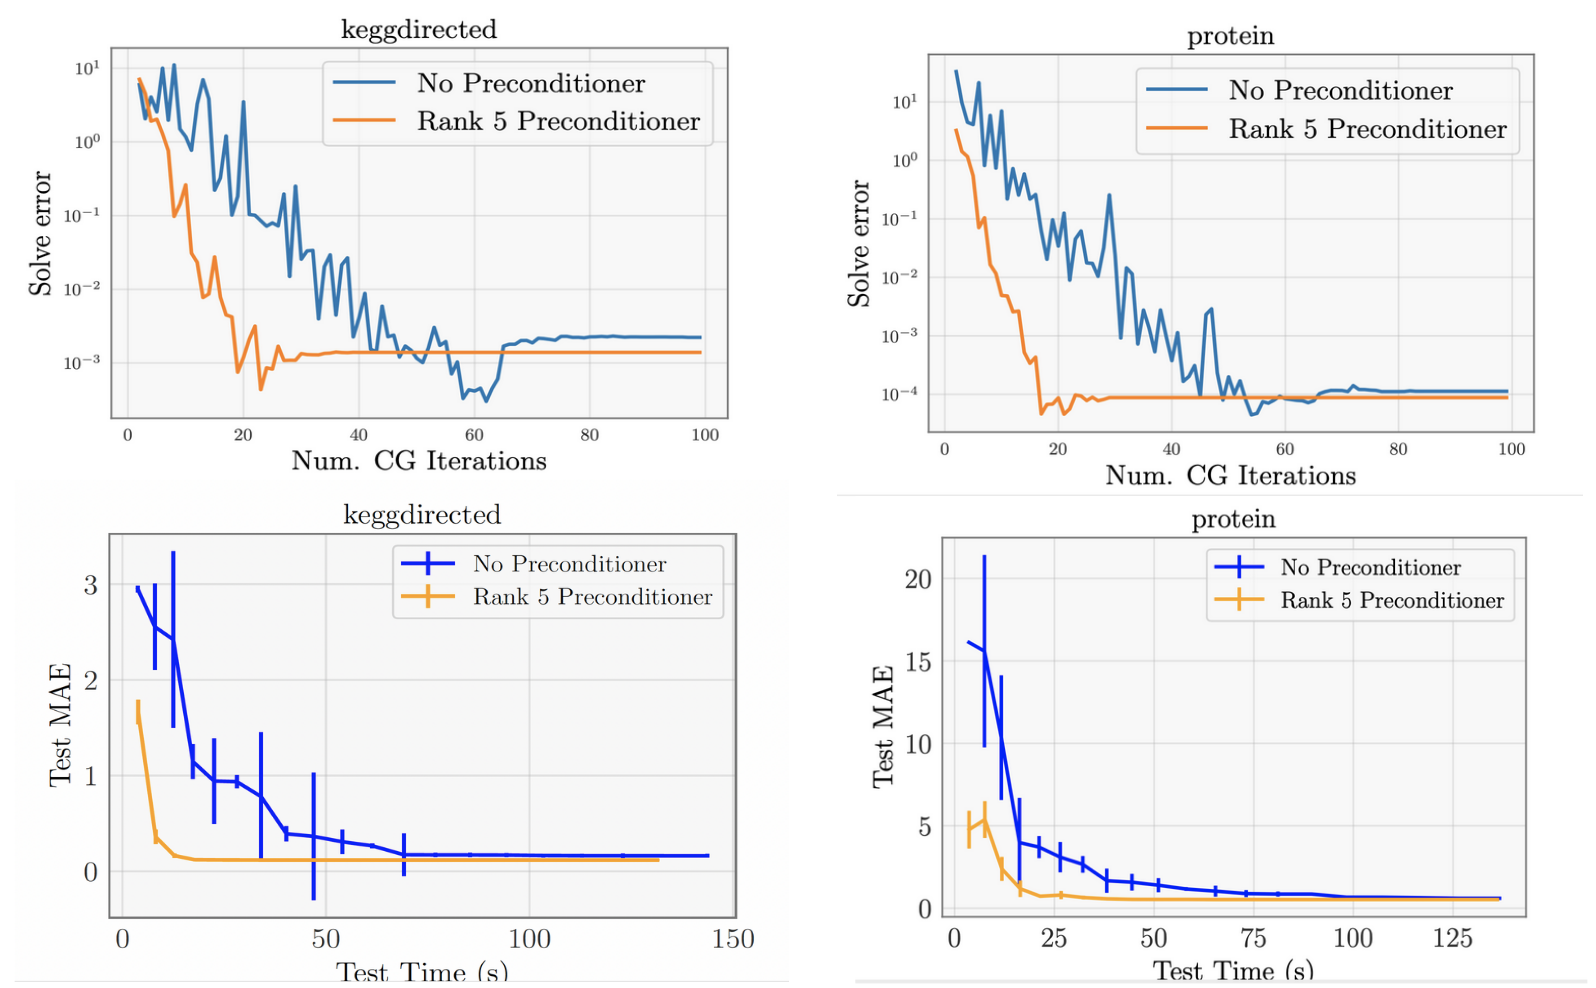


**The Modified Batch Conjugate Gradients (mBCG) Algorithm of GPyTorch**

GPyTorch is distinguished by the introduction of a modified batch conjugate gradients (mBCG) algorithm. This algorithm reformulates all the computations needed for solving linear systems with CG and computing Lanczos tridiagonalization into a large batch matrix matrix multiplication, which can be heavily parallelized. Moreover, the algorithm computes all of the Lanczos tridiagional matrices from the coefficient of conjugate gradients at an additional cost of $\mathcal{O}(1)$ per iteration, without ever needing to explicitly run Lanczos quadrature! Each iteration of mBCG requires one matrix-matrix multiply with $K$ and an $n \times t$ matrix for $t$ probe vectors, leading to $\mathcal{O}(nt)$ space and $\mathcal{O}(n^2t)$ time (or faster if we exploit structure in $K$). Careful partioning can further improve memory requirements.

Each step of the algorithm is carefully laid out in detail in the GPyTorch paper (https://arxiv.org/abs/1809.11165). In short, mBCG takes as input a matrix $\left[\begin{array}{cccc}y & z_{1} & \cdots & z_{t}\end{array}\right]$, where $y$ is the data vector and $z_1,\dots,z_t$ are probe vectors, and outputs:
\begin{equation}
  \label{eq:mod_cg_call}
  \left[\begin{array}{cccc}u_{0} & u_{1} & \cdots & u_{t}\end{array}\right] = K^{-1}\left[\begin{array}{cccc}y & z_{1} & \cdots & z_{t}\end{array}\right]\;\;\;\;\textrm{and}\;\;\;\; {T}_{1},...,{T}_{t}
\end{equation}
where ${T}_{1},\ldots,{T}_{t}$ are partial Lanczos tridiagonalizations of $K$ with respect to the probe vectors $z_{1},\ldots,z_{t}$. To accommodate the pivoted Cholesky preconditioner $P$, the probe vectors are sampled from $\mathcal{N}(0,P)$. 


**Partitioning**

If we wish to multiply an $n \times n$ matrix $K$ against a vector $v$, we can do so by partioning the matrix $K$. We start by partioning the data into $p$ different pieces, leading to a kernel matrix that can also be partioned, where each partition $K_1, \dots, K_p$ is formed by evaluating the kernel matrix over the relevant subsets of the data. In particular, $Kv = \left[K_1v, \dots, K_p v \right]$. We can discard each kernel matrix partition $K_j$ as $K_jv$ has been computed. This approach allows us to exchange sequential but easily parallelizable computations in for memory. GPyTorch sets a constant number of rows per partition, determined by the amount of memory available. By keeping the partition in memory only until the relevant matrix vector product has been computed, the resulting approach has roughly an $\mathcal{O}(n)$ memory requirement in practice. Many further details of the partitioning approach and parallelization can be found in https://arxiv.org/abs/1903.08114.

**Results using GPyTorch**


<img src="https://raw.githubusercontent.com/andrewgordonwilson/d2l-en/vol2-gp/chapter_gaussian-processes/cpugpuspeedup.png" width="500"/>


Cholesky approaches are limited to relatively small datasets. But even for these small datasets, we see substantial relative gains in using a GPU with the mBCG algorithm versus the Cholesky decomposition, which cannot be parallelized to the same extent.

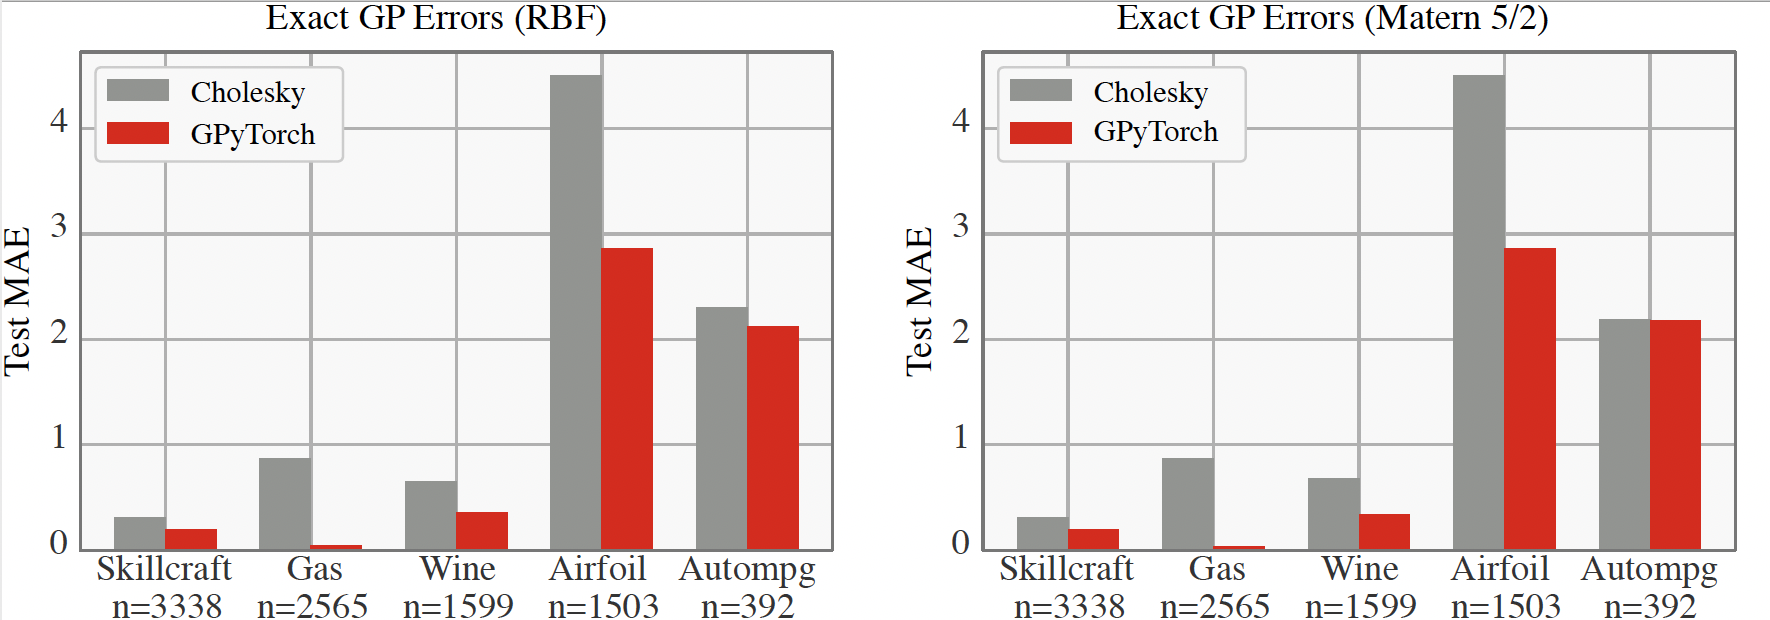
Over a variety of kernel types, the mBCG algorithm also has comparable predictive performance with the Cholesky decomposition. Both are considered "exact" solvers, although each has numerical errors.

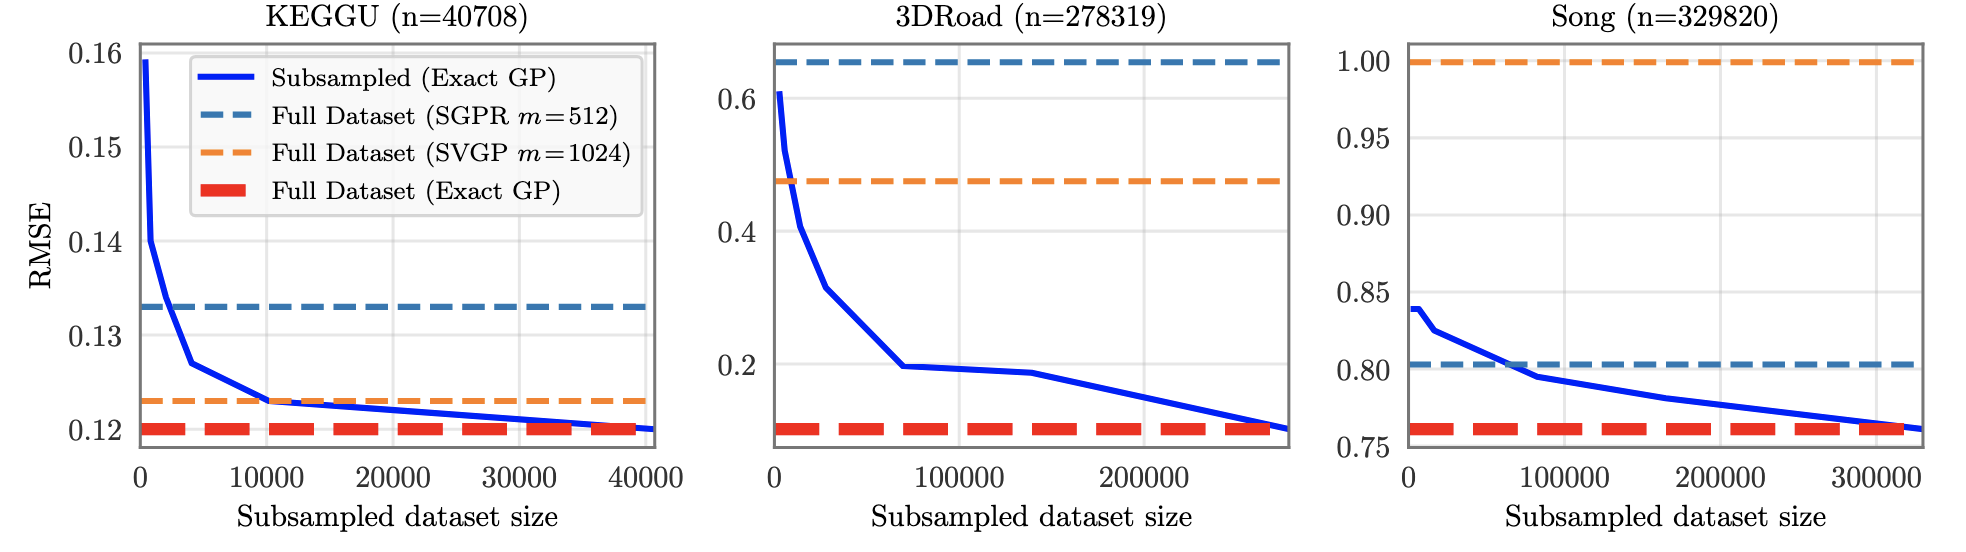
We see that the exact inference provided by mBCG continues to substantially improve in performance as we add more data, in contrast to the SGPR and SVGP methods, which introduce low-rank approximations to the kernel matrix. These low-rank approximations turn the GP into a parametric model, significantly bottlenecking the amount of information the GP is capable of extracting from the training data. mBCG can significantly outperform these alternatives even with access to substantially less data.

<div>
<img src="https://raw.githubusercontent.com/andrewgordonwilson/d2l-en/vol2-gp/chapter_gaussian-processes/runtimes.png" width="500"/>
</div>

The mBCG approach can scale to very large datasets, running GPs on over a million training points on a single 2080Ti GPU in under a day. Such a result would be unthinkable using the Cholesky decomposition. Even storing 500,000 datapoints would require over a terabyte of memory for the Cholesky decomposition. The mBCG approach can also be further accelerated with half-precision representations (saving time partly through saving memory, which leads to less partitioning, and hardware acceleration). See https://arxiv.org/abs/2207.06856 for further details.

## Examples in GPyTorch

_In progress. Let's discuss the best way to present these_. 

All of the Krylov methods we have described are implemented in GPyTorch, alongside pre-conditioners, and tolerances, and other settings that tend to provide good performance over a wide range of problems. If you want to look under the hood, and see the details, they are accessible to you _(add ref)_, but for most cases this won't be required. 

**Simple Regression**

In the inference notebook, we largely coded Gaussian processes from scratch, and ended with a simple regression problem where used GPyTorch. While the example appeared comparatively long, we noted that only minor modification would be needed for much more advanced functionality. To drive this point home, we return to exactly the same example. All of the code can be recycled, with the addition of few additional lines, to use GPU accelerated Krylov methods. In particular, after 

``model = ExactGPModel(train_x, train_y, likelihood)``

we need only add 

``train_x = train_x.cuda()
train_y = train_y.cuda()
model = model.cuda()
likelihood = likelihood.cuda()``


**KeOps For Additional Performance**

GPyTorch is integrated with KeOps for efficient matrix partitioning and multiplication. In general, we highly recommend using the KeOps functionality, as it provides a significant boost in speed. Below, we have an example of how to do this.